<a href="https://colab.research.google.com/github/jenniferamhajduk/AIML_Playground/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm

In [ ]:
from timeit import default_timer
from tqdm.auto import tqdm
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd
print(torch.__version__)
print(torchvision.__version__)


2.1.0+cu121
0.16.0+cu121


In [ ]:
train_data = datasets.CIFAR10(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
  target_transform=None
)

Files already downloaded and verified


In [ ]:
test_data = datasets.CIFAR10(
  root="data",
  train=False,
  download=False,
  transform=ToTensor(),
  target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(50000, 10000)

In [ ]:
image, label = train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [ ]:
classes = train_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
classes_to_idx = train_data.class_to_idx
classes_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
NUM_CLASSES = len(train_data.classes)

In [ ]:
NUM_CLASSES

10

In [ ]:
image.shape, label

(torch.Size([3, 32, 32]), 6)

Text(0.5, 1.0, 'frog')

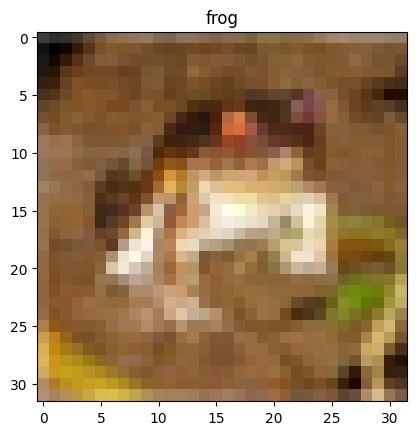

In [ ]:
image, label = train_data[0]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose((1,2,0))
plt.imshow(image)
plt.title(classes[label])

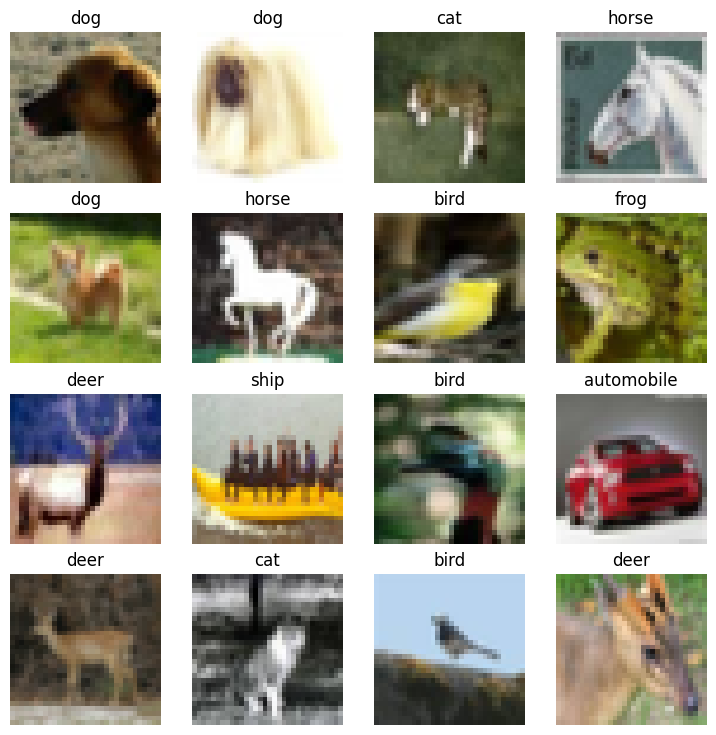

In [ ]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4,4
for i in range(1, rows*cols+1):
  rand_idx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[rand_idx]
  image = image.squeeze(dim=1)
  image = image.numpy()
  image = image.transpose((1,2,0))
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze())
  plt.title(classes[label])
  plt.axis(False)

In [ ]:
BATCH_SIZE=32

In [ ]:
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b728e87f610>,
 <torch.utils.data.dataloader.DataLoader at 0x7b728e87fdf0>)

In [ ]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b728e87f610>, <torch.utils.data.dataloader.DataLoader object at 0x7b728e87fdf0>)
Length of train_dataloader: 1563 batches of 32
Length of test_dataloader: 313 batches of 32


In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

In [ ]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [ ]:
train_features_batch[0], train_labels_batch[0]

(tensor([[[0.5608, 0.5529, 0.5294,  ..., 0.3765, 0.4118, 0.4078],
          [0.5020, 0.5725, 0.6667,  ..., 0.4235, 0.4392, 0.4392],
          [0.3647, 0.4627, 0.7020,  ..., 0.5020, 0.4902, 0.4784],
          ...,
          [0.7333, 0.7216, 0.7020,  ..., 0.7765, 0.7882, 0.8118],
          [0.7333, 0.7098, 0.6863,  ..., 0.7882, 0.8039, 0.8118],
          [0.7647, 0.7333, 0.7294,  ..., 0.8314, 0.8588, 0.8667]],
 
         [[0.3765, 0.3765, 0.3647,  ..., 0.1451, 0.1647, 0.1490],
          [0.3843, 0.4627, 0.5686,  ..., 0.1765, 0.1725, 0.1608],
          [0.2706, 0.3765, 0.6275,  ..., 0.2667, 0.2392, 0.2314],
          ...,
          [0.5882, 0.5804, 0.5569,  ..., 0.6392, 0.6510, 0.6824],
          [0.5882, 0.5608, 0.5333,  ..., 0.6431, 0.6588, 0.6706],
          [0.6314, 0.6000, 0.5922,  ..., 0.6941, 0.7255, 0.7333]],
 
         [[0.2745, 0.2824, 0.2824,  ..., 0.0745, 0.0706, 0.0784],
          [0.3608, 0.4392, 0.5412,  ..., 0.1020, 0.0941, 0.0863],
          [0.2941, 0.3961, 0.6353,  ...,

Image Size; (32, 32, 3)
Label: 6, label size torch.Size([])


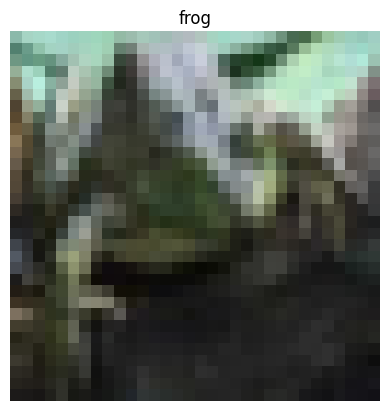

In [ ]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
image, label = train_features_batch[random_idx], train_labels_batch[random_idx]
image = image.squeeze(dim=1)
image = image.numpy()
image = image.transpose((1,2,0))
plt.imshow(image)
plt.title(classes[label])
plt.axis(False)
print(f"Image Size; {image.shape}")
print(f"Label: {label}, label size {label.shape}")


In [ ]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
x, x.shape

(tensor([[[0.5608, 0.5529, 0.5294,  ..., 0.3765, 0.4118, 0.4078],
          [0.5020, 0.5725, 0.6667,  ..., 0.4235, 0.4392, 0.4392],
          [0.3647, 0.4627, 0.7020,  ..., 0.5020, 0.4902, 0.4784],
          ...,
          [0.7333, 0.7216, 0.7020,  ..., 0.7765, 0.7882, 0.8118],
          [0.7333, 0.7098, 0.6863,  ..., 0.7882, 0.8039, 0.8118],
          [0.7647, 0.7333, 0.7294,  ..., 0.8314, 0.8588, 0.8667]],
 
         [[0.3765, 0.3765, 0.3647,  ..., 0.1451, 0.1647, 0.1490],
          [0.3843, 0.4627, 0.5686,  ..., 0.1765, 0.1725, 0.1608],
          [0.2706, 0.3765, 0.6275,  ..., 0.2667, 0.2392, 0.2314],
          ...,
          [0.5882, 0.5804, 0.5569,  ..., 0.6392, 0.6510, 0.6824],
          [0.5882, 0.5608, 0.5333,  ..., 0.6431, 0.6588, 0.6706],
          [0.6314, 0.6000, 0.5922,  ..., 0.6941, 0.7255, 0.7333]],
 
         [[0.2745, 0.2824, 0.2824,  ..., 0.0745, 0.0706, 0.0784],
          [0.3608, 0.4392, 0.5412,  ..., 0.1020, 0.0941, 0.0863],
          [0.2941, 0.3961, 0.6353,  ...,

In [ ]:
output = flatten_model(x)
print(f"Shape before flattening: {x.shape}")
print(f"Shape after flattening: {output.shape}")

Shape before flattening: torch.Size([3, 32, 32])
Shape after flattening: torch.Size([3, 1024])


In [ ]:
class baseline_cifar10(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baseline.parameters(), lr=0.01)


In [ ]:
def Accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [ ]:
def print_training_time(
    start: float,
    end: float,
    device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time: .3f} seconds")

In [ ]:
epochs = 10

In [ ]:
def training_loop(model: torch.nn.Module,
                  epochs: int,
                  train_data_loader: torch.utils.data.DataLoader,
                  test_data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.nn.Module,
                  accuracy):
  print(f"Running: ", model.__class__.__name__)
  train_time_start = default_timer()
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(train_dataloader):
      X = X.to(device)
      y = y.to(device)
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc = Accuracy(y, y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 500 == 0:
        print(f"Processed batch {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)


    test_loss, test_acc = 0,0
    with torch.inference_mode():
      for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc = Accuracy(y_test, y_pred=test_pred.argmax(dim=1))

      test_loss /= len(test_dataloader)
      test_acc  /= len(test_dataloader)

    print(f"Train Accuracy: {train_acc: .2f}%, Train Loss: {loss: .4f} | Test Accuracy: {test_acc: .2f}%, Test Loss: {test_loss: .4f}")
  train_time_end = default_timer()
  total_time = print_training_time(start=train_time_start, end=train_time_end, device=str(next(model.parameters()).device))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def eval_model(
    model: torch.nn.Module,
    test_data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy):
  loss, acc = 0,0
  model.eval().to(device)
  with torch.inference_mode():
    for X, y in tqdm(test_data_loader):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy(y, y_pred.argmax(dim=1))

      loss /= len(test_data_loader)
      acc /= len(test_data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

baseline_results = eval_model(model=baseline,test_data_loader=test_dataloader,loss_fn=loss_fn,accuracy=Accuracy)
baseline_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baseline_cifar10',
 'model_loss': 0.0072535439394414425,
 'model_acc': 0.04012789825457609}

In [ ]:
class baselinev2_cifar10(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
class baselineCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*64,
                  out_features=output_shape)
    )

  def forward(self,x):
    #print("First Layer")
    x = self.conv_block_1(x)
    #print(x.shape)
    #print("Second Layer")
    x = self.conv_block_2(x)
    #print(x.shape)
    #print("Classifier Layer")
    out = self.classifier(x)
    #print(out.shape)
    return out

In [ ]:
def training_loop_cnn(model: torch.nn.Module,
                  epochs: int,
                  train_data_loader: torch.utils.data.DataLoader,
                  test_data_loader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.nn.Module,
                  accuracy):
  print(f"Running: ", model.__class__.__name__)
  train_time_start = default_timer()
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(train_dataloader):
      #print(X.shape)
      X = X.to(device)
      y = y.to(device)
      model.train()
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss
      train_acc = Accuracy(y, y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 500 == 0:
        print(f"Processed batch {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)


    test_loss, test_acc = 0,0
    with torch.inference_mode():
      for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model(X_test)
        test_loss += loss_fn(test_pred, y_test)
        test_acc = Accuracy(y_test, y_pred=test_pred.argmax(dim=1))

      test_loss /= len(test_dataloader)
      test_acc  /= len(test_dataloader)

    print(f"Train Accuracy: {train_acc: .2f}%, Train Loss: {loss: .4f} | Test Accuracy: {test_acc: .2f}%, Test Loss: {test_loss: .4f}")
  train_time_end = default_timer()
  total_time = print_training_time(start=train_time_start, end=train_time_end, device=str(next(model.parameters()).device))

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=baselineCNNmodel.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = 10

In [ ]:
baseline = baseline_cifar10(
    input_shape=3072,
    hidden_units=256,
    output_shape=len(classes)
).to(device)
baseline

baseline_cifar10(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
baselinev2 = baselinev2_cifar10(
  input_shape=3072,
  hidden_units=256,
  output_shape=len(classes)
).to(device)
baselinev2

baselinev2_cifar10(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [ ]:
baselineCNNmodel = baselineCNN(input_shape=3, hidden_units=64, output_shape=10).to(device)
baselineCNNmodel

baselineCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=10, bias=True)
  )
)

In [ ]:
baseline_training = training_loop(model=baseline, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_results = eval_model(model=baseline, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_results

Running:  baseline_cifar10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.2956 | Test Accuracy:  0.02%, Test Loss:  2.3122
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.01%, Train Loss:  2.2846 | Test Accuracy:  0.02%, Test Loss:  2.3122
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3111 | Test Accuracy:  0.02%, Test Loss:  2.3122
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3440 | Test Accuracy:  0.02%, Test Loss:  2.3122
Epoch: 4
Processed batch 0/50000 samples
Processed b

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baseline_cifar10',
 'model_loss': 0.007532526273280382,
 'model_acc': 0.020095745390157776}

In [ ]:
baseline_2_training = training_loop(model=baselinev2, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_2_results = eval_model(model=baselinev2, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_2_results

Running:  baselinev2_cifar10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3294 | Test Accuracy:  0.00%, Test Loss:  2.3069
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3417 | Test Accuracy:  0.00%, Test Loss:  2.3069
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3469 | Test Accuracy:  0.00%, Test Loss:  2.3069
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.00%, Train Loss:  2.3236 | Test Accuracy:  0.00%, Test Loss:  2.3069
Epoch: 4
Processed batch 0/50000 samples
Processed b

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baselinev2_cifar10',
 'model_loss': 0.007474186830222607,
 'model_acc': 6.389825587218412e-05}

In [ ]:
baseline_cnn_training = training_loop_cnn(model=baselineCNNmodel, epochs=epochs, train_data_loader=train_dataloader, test_data_loader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy=Accuracy)
baseline_cnn_results = eval_model(model=baselineCNNmodel, test_data_loader=test_dataloader, loss_fn=loss_fn, accuracy=Accuracy)
baseline_cnn_results

Running:  baselineCNN


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.01%, Train Loss:  2.2988 | Test Accuracy:  0.04%, Test Loss:  2.3025
Epoch: 1
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.02%, Train Loss:  2.2980 | Test Accuracy:  0.04%, Test Loss:  2.3025
Epoch: 2
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.01%, Train Loss:  2.2983 | Test Accuracy:  0.04%, Test Loss:  2.3025
Epoch: 3
Processed batch 0/50000 samples
Processed batch 16000/50000 samples
Processed batch 32000/50000 samples
Processed batch 48000/50000 samples
Train Accuracy:  0.01%, Train Loss:  2.3013 | Test Accuracy:  0.04%, Test Loss:  2.3025
Epoch: 4
Processed batch 0/50000 samples
Processed b

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'baselineCNN',
 'model_loss': 0.007373993285000324,
 'model_acc': 0.04009600041038287}